In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# Chemin du fichier CSV contenant les données
path = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'

# Chargement des données dans un DataFrame pandas
data = pd.read_csv(path)

In [3]:
features = ['MonthlyCharges', 'tenure', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract', 'PaymentMethod']

In [4]:
X = data[features].copy()
y = data['Churn'].copy()
y.replace({'Yes': 1, 'No': 0, ' ': np.nan}, inplace=True)

/var/folders/m4/p71xrbqx639250tkt6rzcx940000gn/T/ipykernel_46295/4054294933.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y.replace({'Yes': 1, 'No': 0, ' ': np.nan}, inplace=True)


In [5]:
X.isna().sum()

MonthlyCharges      0
tenure              0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
Contract            0
PaymentMethod       0
dtype: int64

In [6]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import train_test_split


preprocessor = make_column_transformer(
    (MinMaxScaler(), make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(), make_column_selector(dtype_include=object))
)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

X_train = preprocessor.fit_transform(X_train)

X_test = preprocessor.transform(X_test)

X_train = pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())

In [7]:
import tensorflow as tf
from tensorflow import keras

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=10,
    restore_best_weights=True,
)

In [10]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

/opt/anaconda3/envs/machine_learning/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['f1_score', 'binary_accuracy', 'AUC']
)

<Axes: >

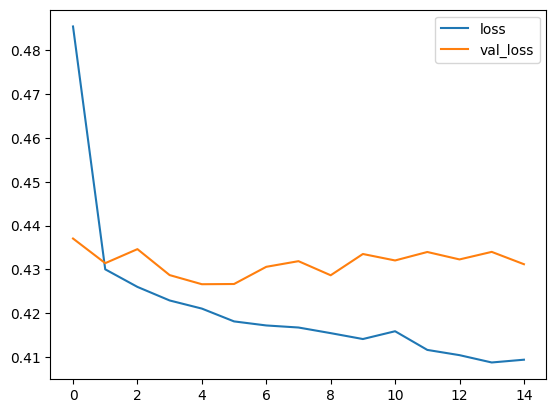

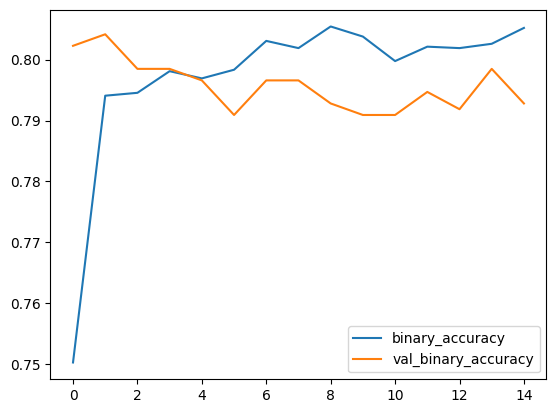

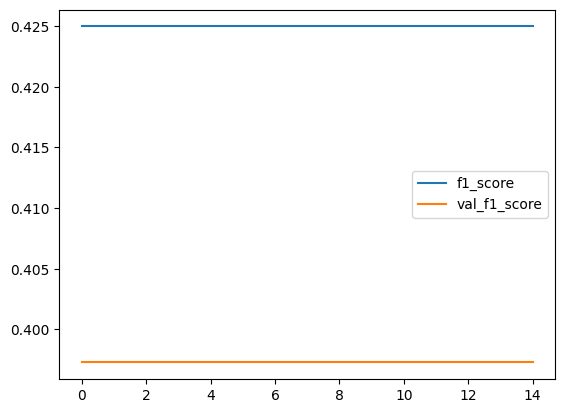

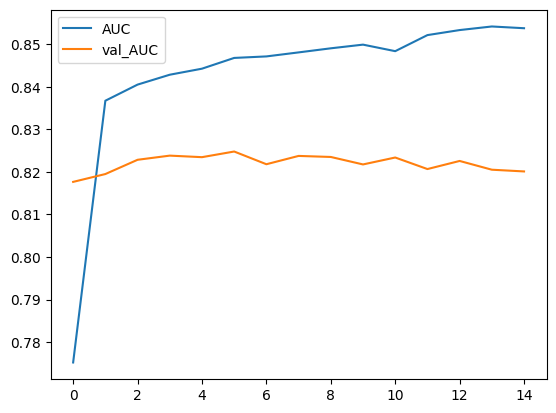

In [12]:
class_weights = {0: 1, 1: 3}
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=1000,
    #class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=0
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()
history_df.loc[:, ['f1_score', 'val_f1_score']].plot()
history_df.loc[:, ['AUC', 'val_AUC']].plot()